#IMPORTING THE REQUIRED LIBRARIES

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
# Reading the data
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
#As we can see that the dataset contains three unnamed columns with null values. So we drop those columns and rename
#the columns v1 and v2 to label and Text, respectively. Since the target variable is in string form, we will 
#encode it numerically using pandas function .map().

In [8]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [9]:
#Let’s visualize the distribution of Ham and Spam data.

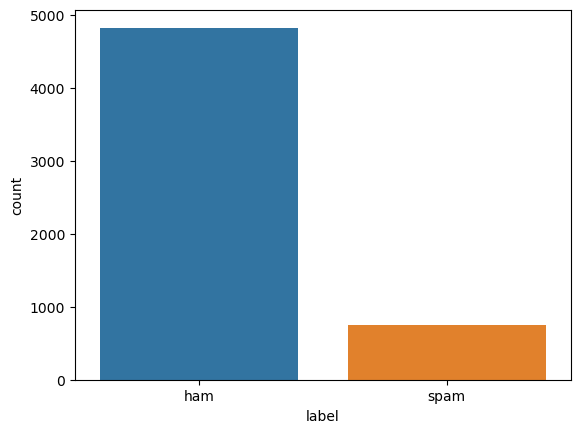

In [10]:
sns.countplot(x=df['label'])
plt.show()

In [11]:
#The ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning 
# model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [12]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [13]:
#Now, let’s find the total number of unique words in the corpus

# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


In [14]:
#Now,  splitting the data into training and testing parts using train_test_split() function.

# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [15]:
#Building the models

#First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep 
#learning models (embeddings, LSTM, etc)

#Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word 
#counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

#TF-IDF (Term Frequency inverse document frequency)
#multinomialNB - multinomial naive bayes classifer
#classification_report and accuracy_score for model's performance


MultinomialNB()

In [17]:
#Performance of baseline model

nb_accuracy = accuracy_score(y_test,baseline_model.predict(X_test_vec))

print(nb_accuracy)

0.9623318385650225


In [18]:
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [19]:
#Confusion matrix for the baseline model



In [20]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
#Model 1: Creating custom Text vectorization and embedding layers:
#Text vectorization is the process of converting text into a numerical representation. 
#Example: Bag of words frequency, Binary Term frequency, etc.;

#A word embedding is a learned representation of text in which words with related meanings have similar representations. 
#Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

#Now, we’ll create a custom text vectorization layer using TensorFlow.

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

MAXTOKENS = total_words_length
OUTPUTLEN = avg_words_len
 
text_vec = TextVectorization(max_tokens=MAXTOKENS, standardize='lower_and_strip_punctuation', output_mode='int', output_sequence_length=OUTPUTLEN)
text_vec.adapt(X_train)


In [23]:
#MAXTOKENS is the maximum size of the vocabulary which was found earlier
#OUTPUTLEN is the length to which the sentences should be padded irrespective of the sentence length.

In [27]:
from keras import layers

embedding_layer = layers.Embedding(input_dim=MAXTOKENS, output_dim=128, embeddings_initializer='uniform')


In [28]:
#input_dim is the size of vocabulary
#output_dim is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedded
#input_length is the length of input sequences

In [29]:
from tensorflow.keras import layers, Model, losses, optimizers

input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = Model(input_layer, output_layer)

model_1.compile(optimizer=optimizers.Adam(), 
                loss=losses.BinaryCrossentropy(label_smoothing=0.5), 
                metrics=['accuracy'])


In [30]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 15, 128)             │       1,994,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,999,041 (7.63 MB)

 Trainable params: 1,999,041 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#Training the model-1

history_1 = model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8554 - loss: 0.6274 - val_accuracy: 0.9695 - val_loss: 0.5783
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9834 - loss: 0.5724 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
  7/140 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9884 - loss: 0.5686

C:\Users\tejan\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9942 - loss: 0.5666 - val_accuracy: 0.9830 - val_loss: 0.5730
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9978 - loss: 0.5647 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9993 - loss: 0.5637 - val_accuracy: 0.9794 - val_loss: 0.5729


<Axes: >

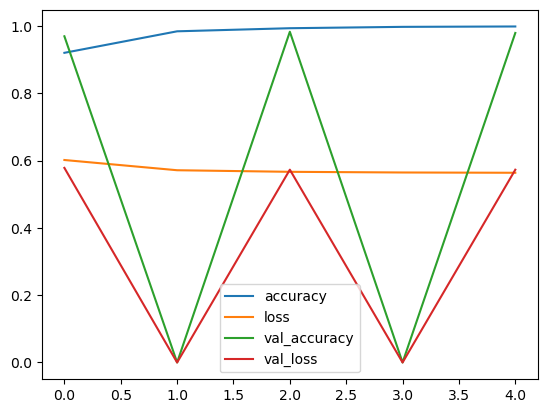

In [32]:
#Plotting the history of model-1

pd.DataFrame(history_1.history).plot()

In [33]:
#Let’s create helper functions for compiling, fitting, and evaluating the model performance.

from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,X_test=X_test, y_test=y_test):
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test, y_test),validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,'precision': precision,'recall': recall,'f1-score': f1}

    return model_results_dict


In [34]:
#Model -2 Bidirectional LSTM

#A bidirectional LSTM (Long short-term memory) is made up of two LSTMs, one accepting input in one direction and 
#the other in the other. BiLSTMs effectively improve the network’s accessible information, boosting the context 
#for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

#Building and compiling the model-2

In [35]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9295 - loss: 0.1581 - val_accuracy: 0.9812 - val_loss: 0.0949
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
  3/140 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 1.0000 - loss: 2.1530e-04 

C:\Users\tejan\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9998 - loss: 3.8855e-04 - val_accuracy: 0.9767 - val_loss: 0.1286
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 5.9420e-05 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 1.0000 - loss: 1.7286e-05 - val_accuracy: 0.9812 - val_loss: 0.1368


In [36]:
#only 2 models

In [37]:
#Analyzing our Model Performance

#We will use the helper function which we created earlier to evaluate model performance.

baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,'Custom-Vec-Embedding Model':model_1_results,'Bidirectional-LSTM Model':model_2_results,}).transpose()

total_results


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.977578,0.977099,0.853333,0.911032
Bidirectional-LSTM Model,0.981166,0.964029,0.893333,0.927336


In [38]:
#Metrics
#All THREE models deliver excellent results. (All of them have greater than 96 percent accuracy), thus comparing them might be difficult.

#Problem
#We have an unbalanced dataset; most of our data points contain the label “ham,” which is natural because most SMS are ham. Accuracy cannot be an appropriate metric in certain situations. Other measurements are required.

#Which metric is better?
#False negative and false positive are significant in this problem. Precision and recall are the metrics that allow us the 
#ability to calculate them, but there is one more, ‘f1-score.’
#The f1-score is the harmonic mean of accuracy and recall. Thus, we can get both with a single shot.
#USE-Transfer learning model gives the best accuracy and f1-score.



In [39]:
# atleast 8 algorithms

# LOGISTIC REGRESSION

In [41]:
from sklearn.model_selection import train_test_split

# Assuming you have a dataset named 'data' with features and labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label_enc'], test_size=0.2, random_state=42)


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Assuming X_train, X_test, y_train, y_test are already defined from previous code
# If not, please refer to the previous code to define them

# Create TF-IDF vectorizer and transform the data
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# Initialize and train logistic regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = logistic_regression_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.77      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 0.967713004484305


# RANDOM FOREST

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train, X_test, y_train, y_test are already defined from previous code
# If not, please refer to the previous code to define them

# Create TF-IDF vectorizer and transform the data
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# Initialize and train Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = random_forest_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.99      0.82      0.90       150

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115

Accuracy: 0.9748878923766816


# K-nearest Neighbours

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train, X_test, y_train, y_test are already defined from previous code
# If not, please refer to the previous code to define them

# Create TF-IDF vectorizer and transform the data
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# Initialize and train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = knn_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       965
           1       1.00      0.37      0.54       150

    accuracy                           0.92      1115
   macro avg       0.96      0.69      0.75      1115
weighted avg       0.92      0.92      0.90      1115

Accuracy: 0.915695067264574


# Decision Trees

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train, X_test, y_train, y_test are already defined from previous code
# If not, please refer to the previous code to define them

# Create TF-IDF vectorizer and transform the data
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# Initialize and train Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = decision_tree_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       965
           1       0.89      0.83      0.86       150

    accuracy                           0.96      1115
   macro avg       0.93      0.91      0.92      1115
weighted avg       0.96      0.96      0.96      1115

Accuracy: 0.9641255605381166


Logistic Regression:
Accuracy: 0.967713004484305
Precision: 0.9913793103448276

Naive Bayes:
Accuracy: 0.9623318385650225
Precision: 1.0

Random Forest:
Accuracy: 0.9748878923766816
Precision: 0.9919354838709677

K-Nearest Neighbors:
Accuracy: 0.915695067264574
Precision: 1.0

Decision Tree:
Accuracy: 0.9641255605381166
Precision: 0.8928571428571429



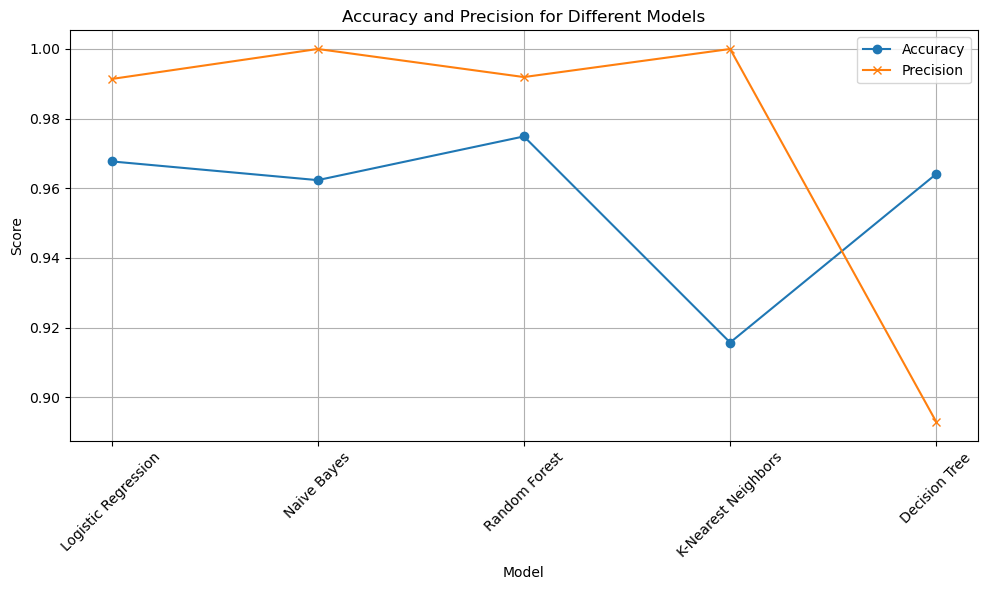


Results Table:
                 Model  Accuracy  Precision
0  Logistic Regression  0.967713   0.991379
1          Naive Bayes  0.962332   1.000000
2        Random Forest  0.974888   0.991935
3  K-Nearest Neighbors  0.915695   1.000000
4        Decision Tree  0.964126   0.892857
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.977578,0.977099,0.853333,0.911032
Bidirectional-LSTM Model,0.981166,0.964029,0.893333,0.927336


In [48]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train, X_test, y_train, y_test are already defined from previous code
# If not, please refer to the previous code to define them

# Create TF-IDF vectorizer and transform the data
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Initialize lists to store accuracy and precision
accuracies = []
precisions = []

# Iterate over models
for name, model in models.items():
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Predictions on the test set
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    # Append to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    
    # Print results
    print(f"{name}:\nAccuracy: {accuracy}\nPrecision: {precision}\n")
    
# Create DataFrame to store results
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': accuracies,
    'Precision': precisions
})

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(results_df['Model'], results_df['Accuracy'], marker='o', label='Accuracy')

# Precision plot
plt.plot(results_df['Model'], results_df['Precision'], marker='x', label='Precision')

# Add labels and legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy and Precision for Different Models')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Display results table
print("\nResults Table:")
print(results_df)



#Analyzing our Model Performance

#We will use the helper function which we created earlier to evaluate model performance.

baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,'Custom-Vec-Embedding Model':model_1_results,'Bidirectional-LSTM Model':model_2_results,}).transpose()

total_results
